In [32]:
# Jupyter Notebook: Risky Location Model for Personal Security Solution

# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Note: Using local Chicago dataset at '../data/chicago_crime_data.csv'.
# Fixed ValueError by handling 'Primary Type' as fallback for 'Crime Type'.
# Sampling 10,000 rows to avoid computational issues and overfitting risks.
# Overfitting in DBSCAN: Too many/small clusters if eps too small or min_samples too low.
# Tune eps (e.g., 0.05-0.2) and min_samples (e.g., 5-20) on subset.
# Tunisia data (Ministry 2014-2015, Numbeo) lacks geolocation, so not usable directly.
# Check https://knoema.com/atlas/Tunisia/datasets or https://opendata.interieur.gov.tn/

# Step 1: Load and preprocess crime data
knoema_file = '../data/tunisia_crime_data.csv'
ministry_file = '../data/tunisia_ministry_crime_data.csv'
chicago_file = '../data/chicago_crime_data.csv'

# Number of rows to sample
sample_size = 20000

# Optimize data types
dtypes = {
    'Latitude': 'float32',
    'Longitude': 'float32',
    'Primary Type': 'category',
    'Date': 'object'
}

try:
    if os.path.exists(knoema_file):
        df = pd.read_csv(knoema_file, dtype=dtypes)
        print("Loaded Knoema Tunisia Crime Data")
    elif os.path.exists(ministry_file):
        df = pd.read_csv(ministry_file, dtype=dtypes)
        print("Loaded Tunisian Ministry of Interior Crime Data")
    elif os.path.exists(chicago_file):
        print(f"Loading local Chicago Crime Data from {chicago_file}")
        # Use chunking for large file
        chunks = pd.read_csv(chicago_file, usecols=['Latitude', 'Longitude', 'Primary Type', 'Date'],
                             dtype=dtypes, chunksize=1000)
        df = pd.concat(chunks)
        print("Columns in Chicago CSV:", df.columns.tolist())  # Debug columns
        # Sample subset
        if len(df) > sample_size:
            df = df.sample(n=sample_size, random_state=42)
            print(f"Sampled {sample_size} rows from Chicago data")
        print("Loaded Chicago data")
    else:
        print(f"No local Chicago data found at {chicago_file}.")
        print("Please download from https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2")
        print("Save as '../data/chicago_crime_data.csv' and rerun.")
        raise FileNotFoundError("Chicago data missing")

    # Check for required columns
    required_cols = ['Latitude', 'Longitude', 'Date']  # Exclude Crime Type for now
    available_cols = df.columns.tolist()
    missing_cols = [col for col in required_cols if col not in available_cols]
    if missing_cols:
        print(f"Error: Missing columns {missing_cols}. Available columns: {available_cols}")
        raise ValueError("Missing required columns")
    
    # Dynamically set crime column
    if 'Crime Type' in available_cols:
        crime_column = 'Crime Type'
    elif 'Primary Type' in available_cols:
        crime_column = 'Primary Type'
    else:
        print(f"Error: Neither 'Crime Type' nor 'Primary Type' found. Available columns: {available_cols}")
        raise ValueError("Missing crime column")

except MemoryError:
    print("MemoryError: Insufficient RAM. Try:")
    print("1. Reduce sample_size (e.g., 5000) in the code.")
    print("2. Close other applications to free memory.")
    print("3. Run on Google Colab (upload chicago_crime_data.csv).")
    raise
except Exception as e:
    print(f"Error loading data: {e}. Ensure '../data/chicago_crime_data.csv' exists.")
    raise

Loading local Chicago Crime Data from ../data/chicago_crime_data.csv
Columns in Chicago CSV: ['Date', 'Primary Type', 'Latitude', 'Longitude']
Sampled 20000 rows from Chicago data
Loaded Chicago data


In [33]:
# Drop rows with missing coordinates
df = df.dropna(subset=['Latitude', 'Longitude'])

# Filter for violent crimes
violent_crimes = ['ASSAULT', 'BATTERY', 'ROBBERY', 'HOMICIDE', 'Violence', 'Atteinte au corps humain']
df = df[df[crime_column].isin(violent_crimes)]

# Extract features
X = df[['Latitude', 'Longitude']].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.1, min_samples=10, metric='euclidean')  # Tune eps/min_samples
clusters = dbscan.fit_predict(X_scaled)

# Add cluster labels
df['Cluster'] = clusters

# Step 3: Assign risk scores
cluster_counts = df[df['Cluster'] != -1]['Cluster'].value_counts()
df['Risk_Score'] = df['Cluster'].map(cluster_counts).fillna(0) / cluster_counts.max()

In [34]:
print(cluster_counts)

Cluster
0    5313
1      31
5      31
2      27
3      24
4      17
8      17
6      14
7      10
9      10
Name: count, dtype: int64


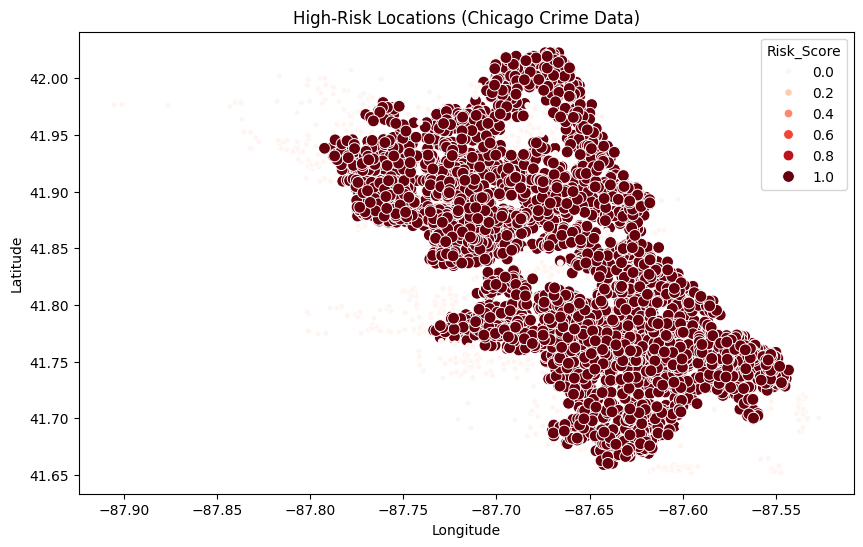

In [35]:

# Step 4: Visualize results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Longitude', y='Latitude', hue='Risk_Score', size='Risk_Score', palette='Reds')
plt.title('High-Risk Locations (Chicago Crime Data)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [39]:
# Step 5: Predict risk score
def predict_risk_score(lat, lon, model, scaler, cluster_counts):
    X_new = np.array([[lat, lon]], dtype=np.float32)
    X_new_scaled = scaler.transform(X_new)
    # Find nearest core point
    if len(model.components_) == 0:
        print("No core points in model. Increase sample_size or adjust eps/min_samples.")
        return 0.0
    distances = np.sqrt(((X_new_scaled - model.components_)**2).sum(axis=1))
    nearest_idx = np.argmin(distances)
    if distances[nearest_idx] <= model.eps:
        cluster = model.labels_[model.core_sample_indices_[nearest_idx]]
        score = cluster_counts.get(cluster, 0) / (cluster_counts.max() if not cluster_counts.empty else 1)
        print(f"Assigned to cluster {cluster} with risk score {score:.2f}")
    else:
        print("Point classified as noise (distance > eps)")
        score = 0.0
    return score

# Example predictions (Chicago coordinates)
test_points = [
    (41.8865, -87.6220),  # Chicago city center
    (41.8781, -87.6298),  # Downtown Chicago
    (41.9380, -87.8160)   # Near North Side
]
for lat, lon in test_points:
    risk_score = predict_risk_score(lat, lon, dbscan, scaler, cluster_counts)
    print(f'Risk Score for ({lat}, {lon}): {risk_score:.2f}')

# Step 6: Save model
import joblib
joblib.dump(dbscan, 'risky_location_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

Assigned to cluster 0 with risk score 1.00
Risk Score for (41.8865, -87.622): 1.00
Assigned to cluster 0 with risk score 1.00
Risk Score for (41.8781, -87.6298): 1.00
Point classified as noise (distance > eps)
Risk Score for (41.938, -87.816): 0.00


['scaler.pkl']

In [37]:
!python -c "import pandas as pd; print(pd.read_csv('../data/chicago_crime_data.csv', nrows=5)[['Latitude', 'Longitude', 'Primary Type', 'Date']])"

    Latitude  Longitude                Primary Type                    Date
0        NaN        NaN  OFFENSE INVOLVING CHILDREN  07/29/2022 03:39:00 AM
1        NaN        NaN                   NARCOTICS  01/03/2023 04:44:00 PM
2  41.908418 -87.677407                     ROBBERY  08/10/2020 09:45:00 AM
3        NaN        NaN         CRIM SEXUAL ASSAULT  08/26/2017 10:00:00 AM
4  41.886018 -87.633938             CRIMINAL DAMAGE  09/06/2023 05:00:00 PM
